In [ ]:
#| echo: false

# This cell will not be rendered but is to hide warnings and limit the rows shown

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# Seasonal Exponential Smoothing Model

> Step-by-step guide on using the `SeasonalExponentialSmoothing Model` with `Statsforecast`.

During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation` in other.

The text in this article is largely taken from:
1. [Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python.](https://link.springer.com/book/10.1007/978-3-031-13584-2) 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)”](https://otexts.com/fpp3/tscv.html).

## Table of Contents

* [Introduction](#introduction)
* [Seasonal Exponential Smoothing](#model)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of SeasonalExponentialSmoothing with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## Introduction <a class="anchor" id="introduction"></a>

Simple Exponential Smoothing (SES) is a forecasting method that uses a weighted average of historical values to predict the next value. The weight is assigned to the most recent values, and the oldest values receive a lower weight. This is because SES assumes that more recent values are more relevant to predicting the future than older values.

SES is implemented by a simple formula:

$$\hat{y}_{T+1|T} = \alpha y_T + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2}+ \cdots,$$

The smoothing factor controls the amount of weight that is assigned to the most recent values. A higher α value means more weight will be assigned to newer values, while a lower α value means more weight will be assigned to older values.

Seasonality in time series refers to the regular, repeating pattern of variation in a time series over a specified period of time. 

Seasonality can be a challenge to deal with in time series analysis, as it can obscure the underlying trend in the data. 

Seasonality is an important factor to consider when analyzing time series data. By understanding the seasonal patterns in the data, it is possible to make more accurate forecasts and better decisions.

## Seasonal Exponential Smoothing Model <a class="anchor" id="model"></a>


The simplest of the exponentially smoothing methods is naturally called simple exponential smoothing (SES). This method is suitable for forecasting data with no clear trend or seasonal pattern.

Using the naïve method, all forecasts for the future are equal to the last observed value of the series,
$$\hat{y}_{T+h|T} = y_{T},$$

for $h=1,2,\dots$. Hence, the naïve method assumes that the most recent observation is the only important one, and all previous observations provide no information for the future. This can be thought of as a weighted average where all of the weight is given to the last observation.

Using the average method, all future forecasts are equal to a simple average of the observed data,
$$\hat{y}_{T+h|T} = \frac1T \sum_{t=1}^T y_t,$$

for $h=1,2,\dots$ Hence, the average method assumes that all observations are of equal importance, and gives them equal weights when generating forecasts.

We often want something between these two extremes. For example, it may be sensible to attach larger weights to more recent observations than to observations from the distant past. This is exactly the concept behind simple exponential smoothing. Forecasts are calculated using weighted averages, where the weights decrease exponentially as observations come from further in the past — the smallest weights are associated with the oldest observations:

\begin{equation}
  \hat{y}_{T+1|T} = \alpha y_T + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2}+ \cdots,   \tag{1}
\end{equation}

where $0 \le \alpha \le 1$ is the smoothing parameter. The one-step-ahead forecast for time $T+1$ is a weighted average of all of the observations in the series $y_1,\dots,y_T$. The rate at which the weights decrease is controlled by the parameter $\alpha$.

For any $\alpha$ between 0 and 1, the weights attached to the observations decrease exponentially as we go back in time, hence the name “exponential smoothing”. If $\alpha$ is small (i.e., close to 0), more weight is given to observations from the more distant past. If $\alpha$ is large (i.e., close to 1), more weight is given to the more recent observations. For the extreme case where $\alpha=1$, $\hat{y}_{T+1|T}=y_T$ and the forecasts are equal to the naïve forecasts.



### How do you know the value of the seasonal parameters?

To determine the value of the seasonal parameter s in the Seasonally Adjusted `Simple Exponential Smoothing (SES Seasonally Adjusted) model`, different methods can be used, depending on the nature of the data and the objective of the analysis.

Here are some common methods to determine the value of the seasonal parameter $s$:

1. **Visual Analysis:** A visual analysis of the time series data can be performed to identify any seasonal patterns. If a clear seasonal pattern is observed in the data, the length of the seasonal period can be used as the value of $s$.

2. **Statistical methods:** Statistical techniques, such as autocorrelation, can be used to identify seasonal patterns in the data. The value of $s$ can be the number of periods in which a significant peak in the autocorrelation function is observed.

3. **Frequency Analysis:** A frequency analysis of the data can be performed to identify seasonal patterns. The value of $s$ can be the number of periods in which a significant peak in the frequency spectrum is observed. [see](https://robjhyndman.com/hyndsight/seasonal-periods/)

4. **Trial and error:** You can try different values of $s$ and select the value that results in the best fit of the model to the data.

It is important to note that the choice of the value of $s$ can significantly affect the `accuracy` of the seasonally adjusted SES model predictions. Therefore, it is recommended to test different values of $s$ and evaluate the performance of the model using appropriate evaluation measures before selecting the final value of $s$.

### How can we validate the simple exponential smoothing model with seasonal adjustment?

To validate the Seasonally Adjusted Simple Exponential Smoothing (SES Seasonally Adjusted) model, different theorems and evaluation measures can be used, depending on the objective of the analysis and the nature of the data.

Here are some common theorems used to validate the seasonally adjusted SES model:

1. Gauss-Markov Theorem: This theorem states that, if certain conditions are met, the least squares estimator is the best linear unbiased estimator. In the case of the seasonally adjusted SES, the model parameters are estimated using least squares, so the Gauss-Markov theorem can be used to assess the quality of model fit.

2. Unit Root Theorem: This theorem is used to determine if a time series is stationary or not. If a time series is non-stationary, the seasonally adjusted SES model is not appropriate, since it assumes that the time series is stationary. Therefore, the unit root theorem is used to assess the stationarity of the time series and determine whether the seasonally adjusted SES model is appropriate.

3. Ljung-Box Theorem: This theorem is used to assess the goodness of fit of the model and to determine if the model residuals are white noise. If the residuals are white noise, the model fits the data well and the model predictions are accurate. The Ljung-Box theorem is used to test whether the model residuals are independent and uncorrelated.

In addition to these theorems, various evaluation measures, such as root mean square error (MSE), mean absolute error (MAE), and coefficient of determination (R²), can be used to evaluate the performance of the seasonally adjusted SES model and compare it with other forecast models.

## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip}
Statsforecast will be needed. To install, see [instructions](../getting-started/0_Installation).
:::

Next, we import plotting libraries and configure the plotting style.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('grayscale') # fivethirtyeight  grayscale  classic
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#008080',  # #212946
    'axes.facecolor': '#008080',
    'savefig.facecolor': '#008080',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#000000',  #2A3459
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)


from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

### Read Data

In [ ]:
import pandas as pd

df=pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/ads.csv")
df.head()

,Time,Ads
0,2017-09-13T00:00:00,80115
1,2017-09-13T01:00:00,79885
2,2017-09-13T02:00:00,89325
3,2017-09-13T03:00:00,101930
4,2017-09-13T04:00:00,121630


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,2017-09-13T00:00:00,80115,1
1,2017-09-13T01:00:00,79885,1
2,2017-09-13T02:00:00,89325,1
3,2017-09-13T03:00:00,101930,1
4,2017-09-13T04:00:00,121630,1


In [ ]:
print(df.dtypes)

ds           object
y             int64
unique_id    object
dtype: object


We can see that our time variable `(ds)` is in an object format, we need to convert to a date format

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore Data with the plot method <a class="anchor" id="plotting"></a>

Plot some series using the plot method from the StatsForecast class. This method prints a random series from the dataset and is useful for basic EDA.

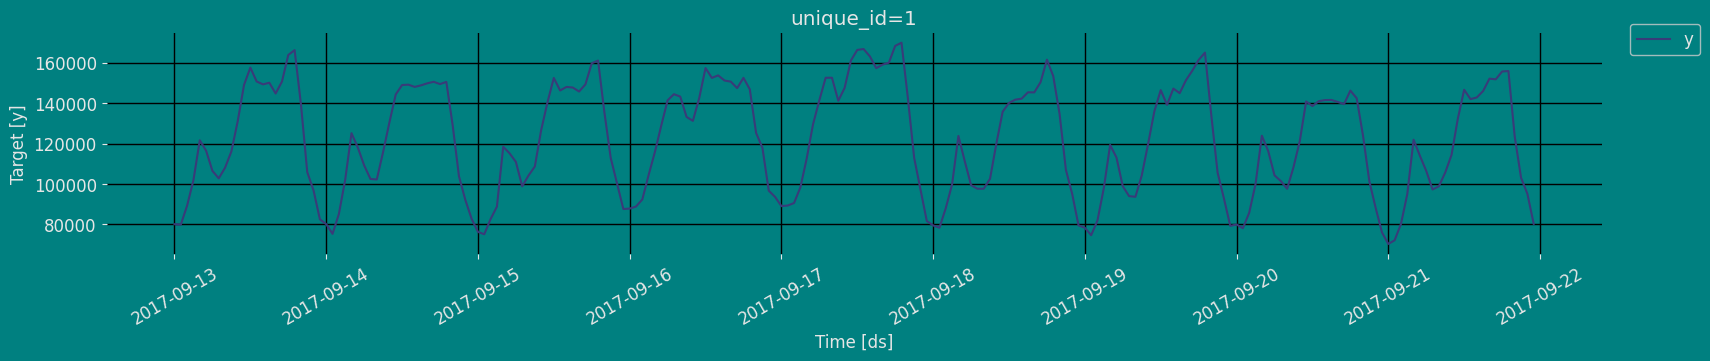

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

### The Augmented Dickey-Fuller Test

An Augmented Dickey-Fuller (ADF) test is a type of statistical test that determines whether a unit root is present in time series data. Unit roots can cause unpredictable results in time series analysis. A null hypothesis is formed in the unit root test to determine how strongly time series data is affected by a trend. By accepting the null hypothesis, we accept the evidence that the time series data is not stationary. By rejecting the null hypothesis or accepting the alternative hypothesis, we accept the evidence that the time series data is generated by a stationary process. This process is also known as stationary trend. The values of the ADF test statistic are negative. Lower ADF values indicate a stronger rejection of the null hypothesis.

Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

Null Hypothesis: Time Series is non-stationary. It gives a time-dependent trend.
Alternate Hypothesis: Time Series is stationary. In another term, the series doesn’t depend on time.

ADF or t Statistic < critical values: Reject the null hypothesis, time series is stationary.
ADF or t Statistic > critical values: Failed to reject the null hypothesis, time series is non-stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")

In [ ]:
Augmented_Dickey_Fuller_Test_func(df["y"],'Ads')

Dickey-Fuller test results for columns: Ads
Test Statistic         -7.089634e+00
p-value                 4.444804e-10
No Lags Used            9.000000e+00
                            ...     
Critical Value (1%)    -3.462499e+00
Critical Value (5%)    -2.875675e+00
Critical Value (10%)   -2.574304e+00
Length: 7, dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary


### Autocorrelation plots

The important characteristics of Autocorrelation (ACF) and Partial Autocorrelation (PACF) are as follows:

Autocorrelation (ACF):
1. Identify patterns of temporal dependence: The ACF shows the correlation between an observation and its lagged values at different time intervals. Helps identify patterns of temporal dependency in a time series, such as the presence of trends or seasonality.

2. Indicates the "memory" of the series: The ACF allows us to determine how much past observations influence future ones. If the ACF shows significant autocorrelations in several lags, it indicates that the series has a long-term memory and that past observations are relevant to predict future ones.

3. Helps identify MA (moving average) models: The shape of the ACF can reveal the presence of moving average components in the time series. Lags where the ACF shows a significant correlation may indicate the order of an MA model.

Partial Autocorrelation (PACF):
1. Identify direct dependence: Unlike the ACF, the PACF eliminates the indirect effects of intermediate lags and measures the direct correlation between an observation and its lagged values. It helps to identify the direct dependence between an observation and its lag values, without the influence of intermediate lags.

2. Helps to identify AR (autoregressive) models: The shape of the PACF can reveal the presence of autoregressive components in the time series. Lags in which the PACF shows a significant correlation may indicate the order of an AR model.

3. Used in conjunction with the ACF: The PACF is used in conjunction with the ACF to determine the order of an AR or MA model. By analyzing both the ACF and the PACF, significant lags can be identified and a model suitable for time series analysis and forecasting can be built.

In summary, the ACF and the PACF are complementary tools in time series analysis that provide information on time dependence and help identify the appropriate components to build forecast models.

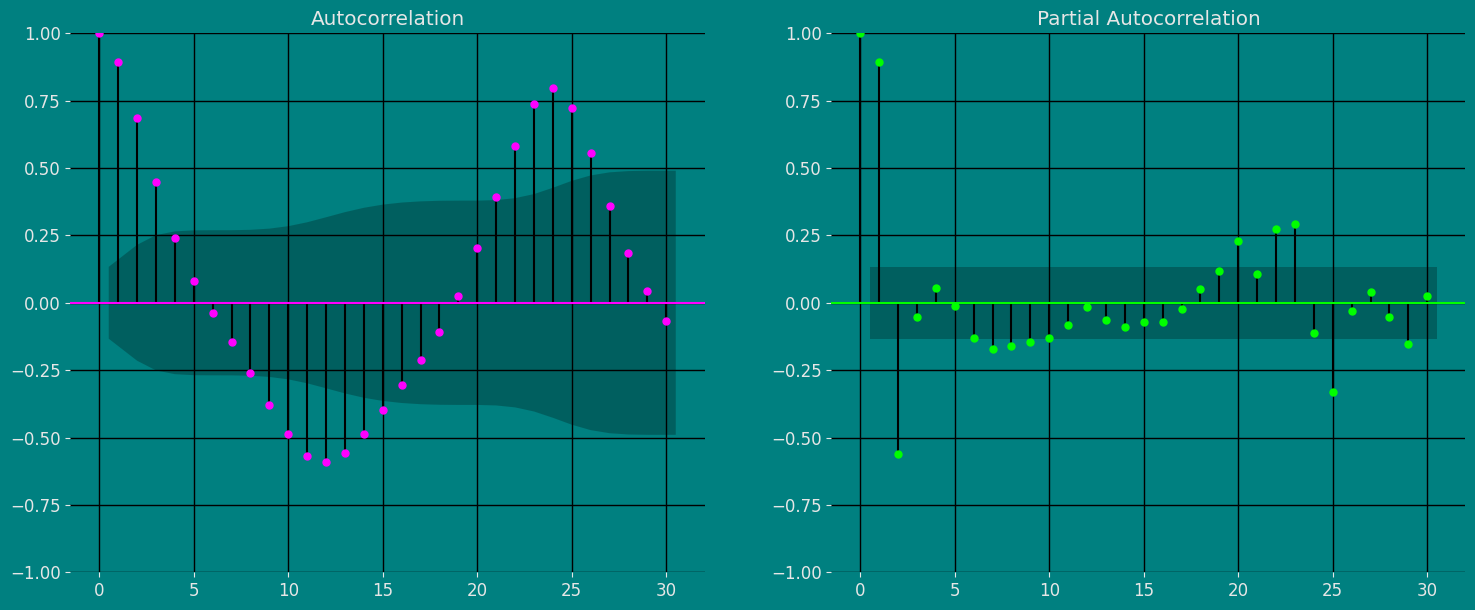

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

### Decomposition of the time series

How to decompose a time series and why?

In time series analysis to forecast new values, it is very important to know past data. More formally, we can say that it is very important to know the patterns that values follow over time. There can be many reasons that cause our forecast values to fall in the wrong direction. Basically, a time series consists of four components. The variation of those components causes the change in the pattern of the time series. These components are:

* **Level:** This is the primary value that averages over time.
* **Trend:** The trend is the value that causes increasing or decreasing patterns in a time series.
* **Seasonality:** This is a cyclical event that occurs in a time series for a short time and causes short-term increasing or decreasing patterns in a time series.
* **Residual/Noise:** These are the random variations in the time series.

Combining these components over time leads to the formation of a time series. Most time series consist of level and noise/residual and trend or seasonality are optional values.

If seasonality and trend are part of the time series, then there will be effects on the forecast value. As the pattern of the forecasted time series may be different from the previous time series.

The combination of the components in time series can be of two types:
* Additive
* Multiplicative

### Additive time series

If the components of the time series are added to make the time series. Then the time series is called the additive time series. By visualization, we can say that the time series is additive if the increasing or decreasing pattern of the time series is similar throughout the series. The mathematical function of any additive time series can be represented by:
$$y(t) = level + Trend + seasonality + noise$$

### Multiplicative time series

If the components of the time series are multiplicative together, then the time series is called a multiplicative time series. For visualization, if the time series is having exponential growth or decline with time, then the time series can be considered as the multiplicative time series. The mathematical function of the multiplicative time series can be represented as.

$$y(t) = Level * Trend * seasonality * Noise$$

### Additive

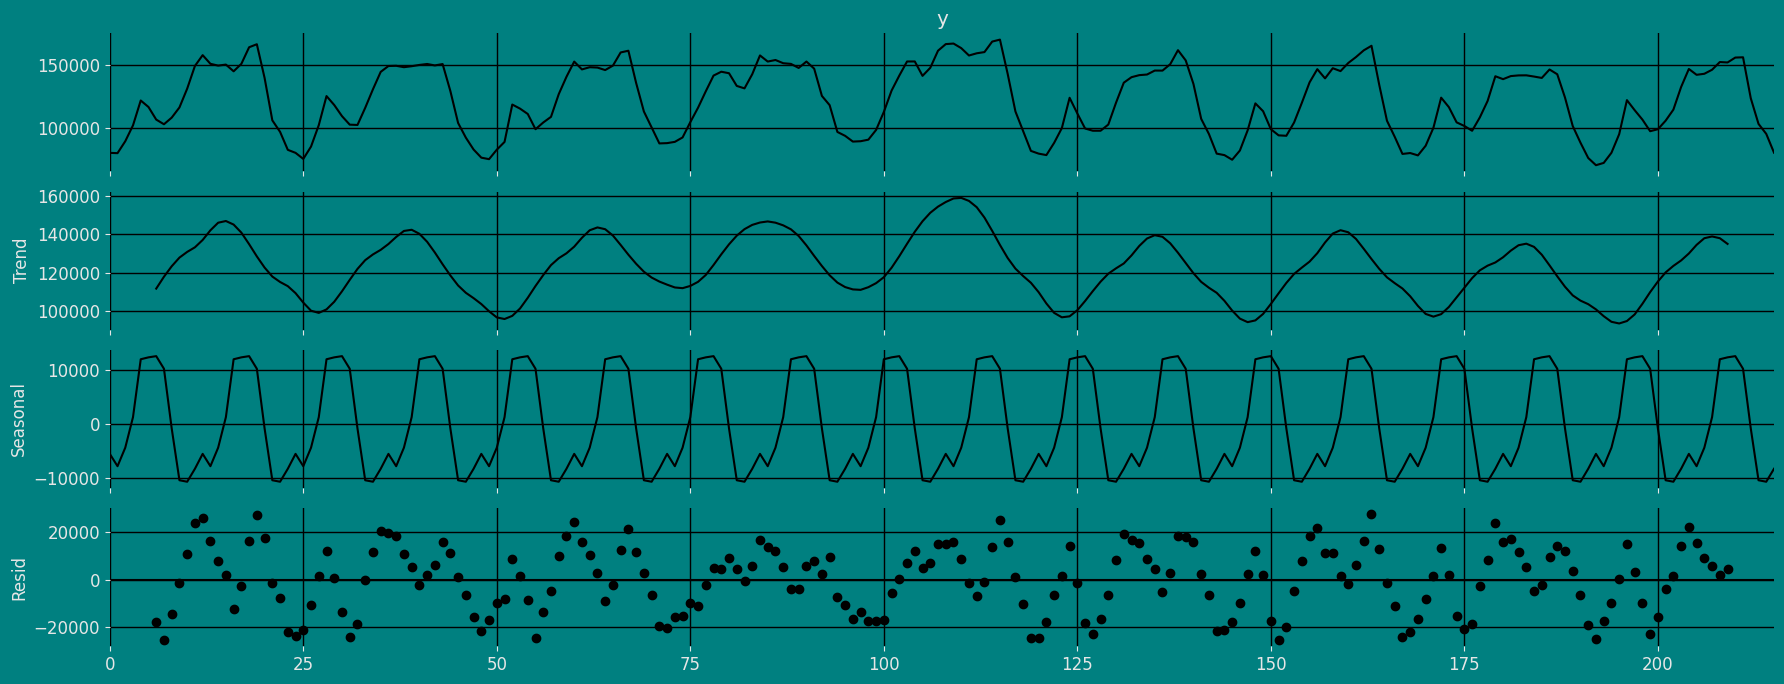

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
a = seasonal_decompose(df["y"], model = "additive", period=12)
a.plot();

### Multiplicative

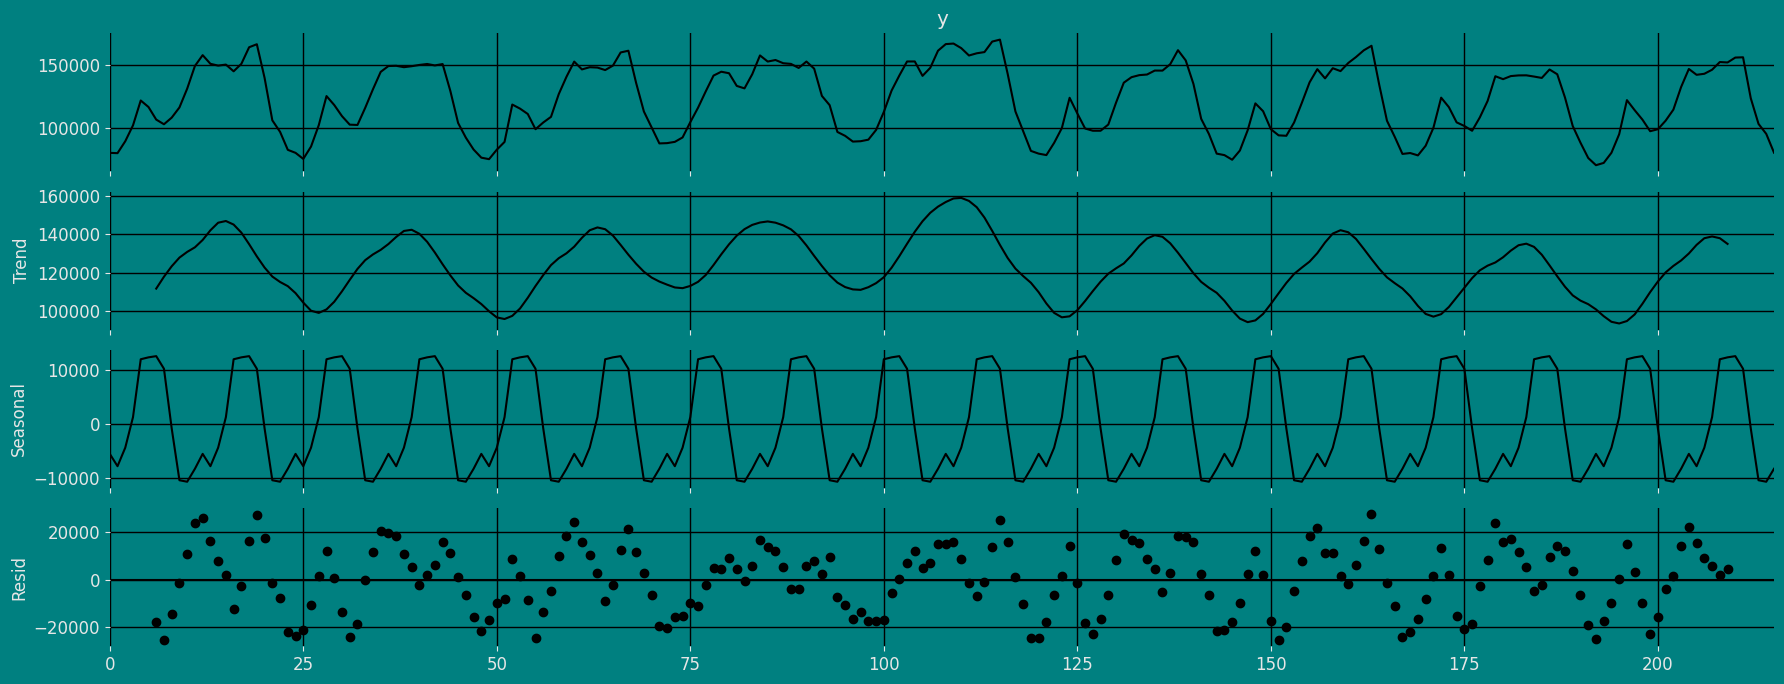

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
a = seasonal_decompose(df["y"], model = "Multiplicative", period=12)
a.plot();

## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets

1. Data to train our `Seasonal Exponential Smoothing Model`.
2. Data to test our model

For the test data we will use the last 30 hourly to test and evaluate the performance of our model.

In [ ]:
train = df[df.ds<='2017-09-20 17:00:00']
test = df[df.ds>'2017-09-20 17:00:00']

In [ ]:
train.shape, test.shape

((186, 3), (30, 3))

Now let's plot the training data and the test data.

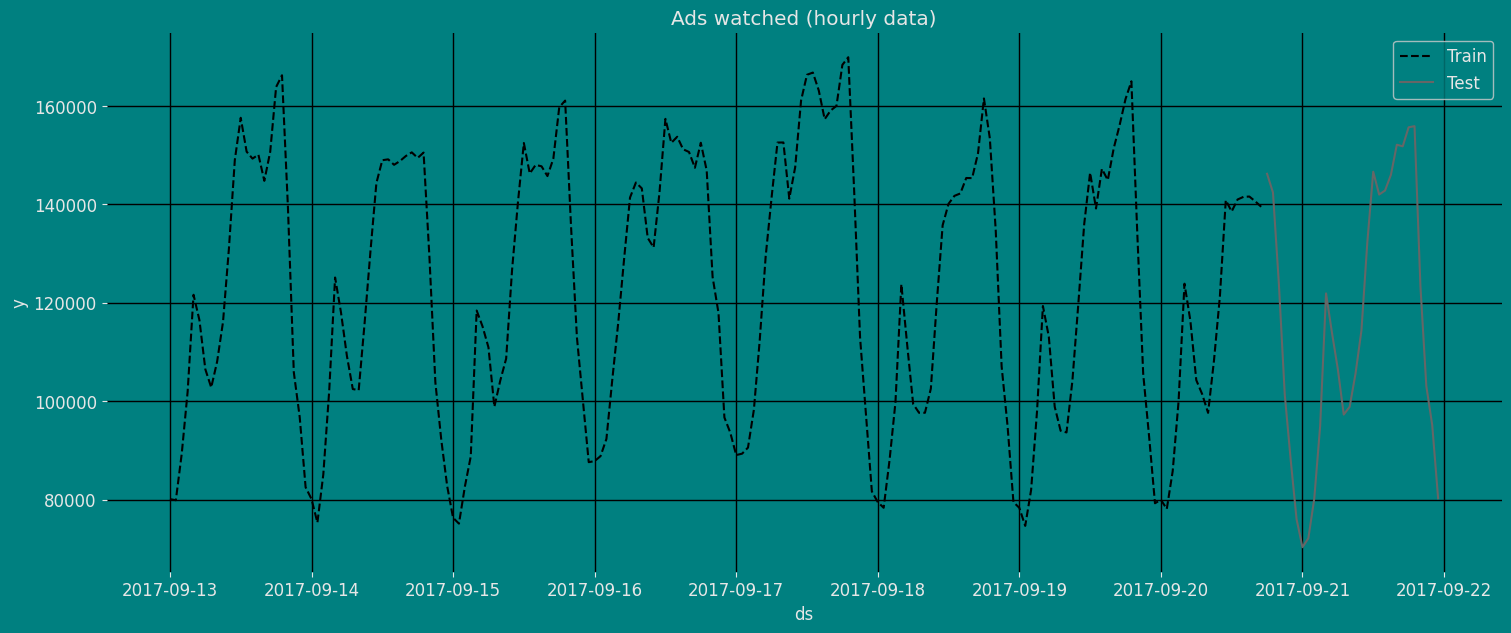

In [ ]:
sns.lineplot(train,x="ds", y="y", label="Train", linestyle="--")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.title("Ads watched (hourly data)");
plt.show()

## Implementation of SeasonalExponentialSmoothing with StatsForecast <a class="anchor" id="implementation"></a>

### Load libraries

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import SeasonalExponentialSmoothing

### Instantiating Model
Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/) by the master, Rob Hyndmann, can be useful for `season_length`.


In [ ]:
season_length = 24 # Hourly data
horizon = len(test) # number of predictions

models = [SeasonalExponentialSmoothing(alpha=0.8, season_length=season_length)]

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [pandas’ available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(models=models, freq='h')

### Fit the Model

In [ ]:
sf.fit(df=train)

StatsForecast(models=[SeasonalES])

Let's see the results of our `Seasonal Exponential Smoothing Model`. We can observe it with the following instruction:

In [ ]:
result=sf.fitted_[0,0].model_
result

{'mean': array([161567.6  , 163186.56 , 134410.94 , 106145.6  ,  93383.164,
         79489.72 ,  79769.   ,  77651.984,  85288.33 ,  99665.31 ,
        123067.336, 115759.51 , 103556.234, 100510.09 ,  97411.65 ,
        107672.88 , 121150.84 , 140041.22 , 140075.19 , 140903.34 ,
        142615.28 , 142360.75 , 142615.6  , 142658.62 ], dtype=float32),
 'fitted': array([       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan, 163840.   , 166235.   , 139520.   ,
        105895.   ,  9678

Let us now visualize the fitted values of our models.

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.

In [ ]:
fitted=pd.DataFrame(result.get("fitted"), columns=["fitted"])
fitted["ds"]=df["ds"]
fitted

,fitted,ds
0,NaN,2017-09-13 00:00:00
1,NaN,2017-09-13 01:00:00
2,NaN,2017-09-13 02:00:00
...,...,...
183,145443.734375,2017-09-20 15:00:00
184,150638.000000,2017-09-20 16:00:00
185,155233.093750,2017-09-20 17:00:00


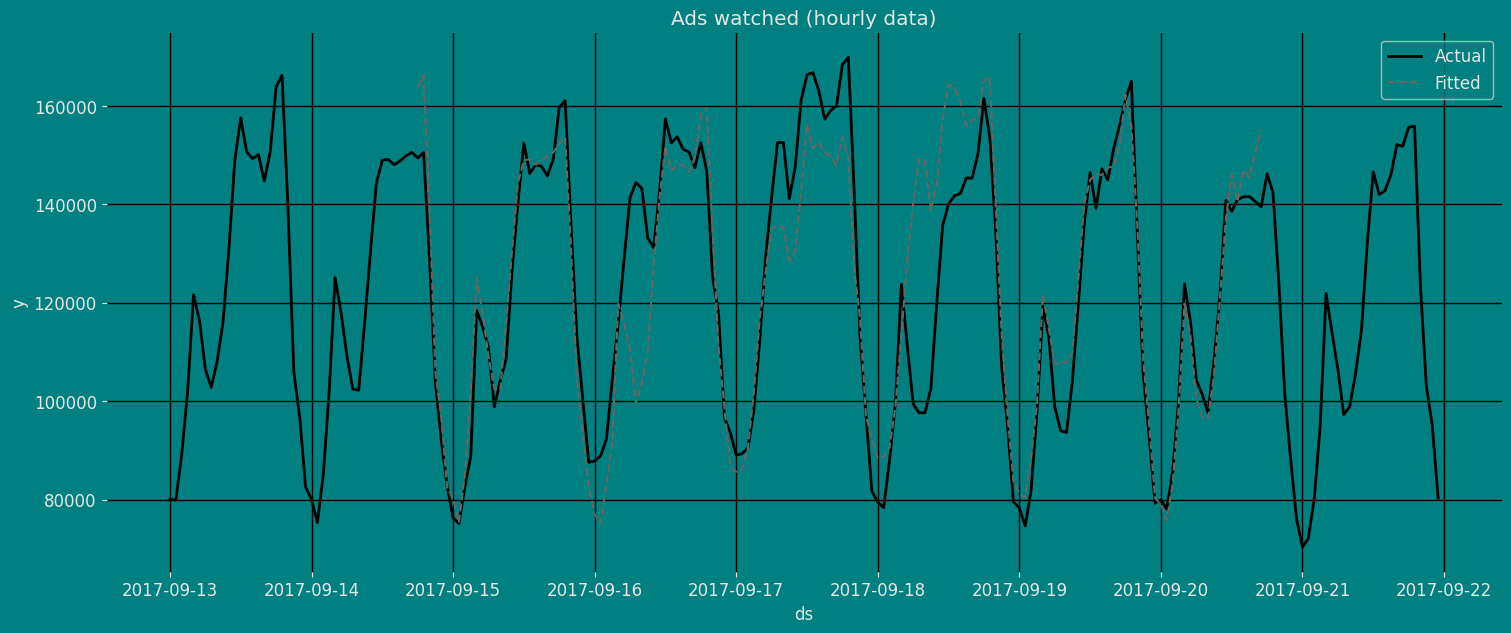

In [ ]:
sns.lineplot(df, x="ds", y="y", label="Actual", linewidth=2)
sns.lineplot(fitted,x="ds", y="fitted", label="Fitted", linestyle="--" )

plt.title("Ads watched (hourly data)");
plt.show()

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 30 hours ahead.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min.

In [ ]:
Y_hat = sf.forecast(df=train, h=horizon, fitted=True)
Y_hat

,unique_id,ds,SeasonalES
0,1,2017-09-20 18:00:00,161567.593750
1,1,2017-09-20 19:00:00,163186.562500
2,1,2017-09-20 20:00:00,134410.937500
...,...,...,...
27,1,2017-09-21 21:00:00,106145.601562
28,1,2017-09-21 22:00:00,93383.164062
29,1,2017-09-21 23:00:00,79489.718750


In [ ]:
values=sf.forecast_fitted_values()
values.head()

,unique_id,ds,y,SeasonalES
0,1,2017-09-13 00:00:00,80115.0,NaN
1,1,2017-09-13 01:00:00,79885.0,NaN
2,1,2017-09-13 02:00:00,89325.0,NaN
3,1,2017-09-13 03:00:00,101930.0,NaN
4,1,2017-09-13 04:00:00,121630.0,NaN


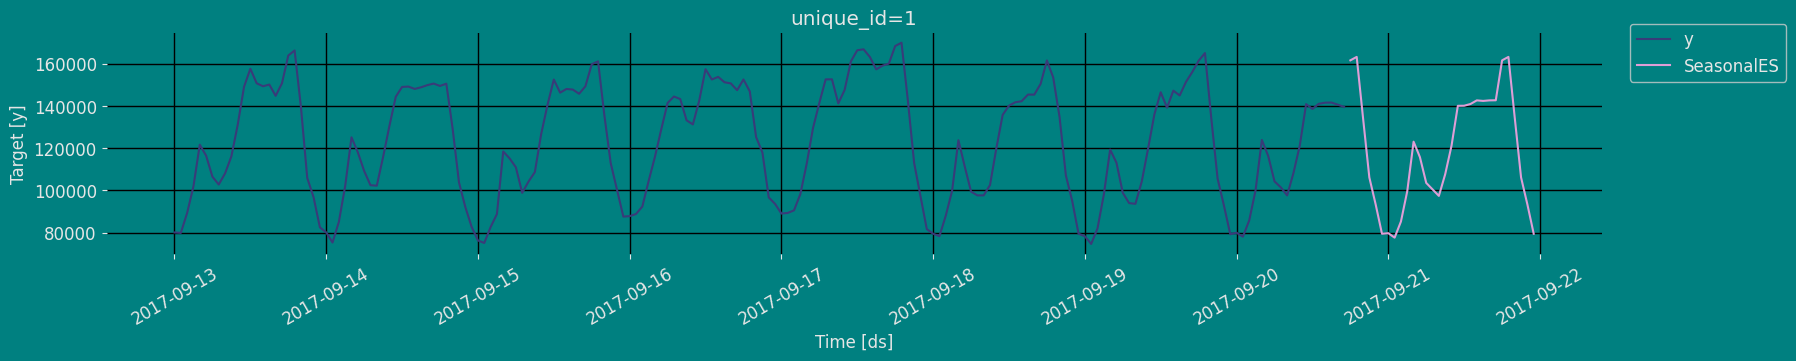

In [ ]:
sf.plot(train, Y_hat)

### Predict method with confidence interval

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 30 hourly ahead.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [ ]:
forecast_df = sf.predict(h=horizon)
forecast_df

,unique_id,ds,SeasonalES
0,1,2017-09-20 18:00:00,161567.593750
1,1,2017-09-20 19:00:00,163186.562500
2,1,2017-09-20 20:00:00,134410.937500
...,...,...,...
27,1,2017-09-21 21:00:00,106145.601562
28,1,2017-09-21 22:00:00,93383.164062
29,1,2017-09-21 23:00:00,79489.718750


## Cross-validation <a class="anchor" id="cross_validate"></a>

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months `(n_windows=5)`, forecasting every second months `(step_size=12)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 30 hourly ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
crossvalidation_df = sf.cross_validation(df=df,
                                         h=horizon,
                                         step_size=12,
                                         n_windows=3)

The crossvaldation_df object is a new data frame that includes the following columns:

*  `unique_id:` series identifier.
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the n_windows.
* `y:` true value
* `"model":` columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df

,unique_id,ds,cutoff,y,SeasonalES
0,1,2017-09-19 18:00:00,2017-09-19 17:00:00,161385.0,162297.953125
1,1,2017-09-19 19:00:00,2017-09-19 17:00:00,165010.0,155892.812500
2,1,2017-09-19 20:00:00,2017-09-19 17:00:00,134090.0,135694.703125
...,...,...,...,...,...
87,1,2017-09-21 21:00:00,2017-09-20 17:00:00,103080.0,106145.601562
88,1,2017-09-21 22:00:00,2017-09-20 17:00:00,95155.0,93383.164062
89,1,2017-09-21 23:00:00,2017-09-20 17:00:00,80285.0,79489.718750


## Model Evaluation <a class="anchor" id="evaluate"></a>

Now we are going to evaluate our model with the results of the predictions, we will use different types of metrics MAE, MAPE, MASE, RMSE, SMAPE to evaluate the accuracy.

In [ ]:
from functools import partial

import utilsforecast.losses as ufl
from utilsforecast.evaluation import evaluate

In [ ]:
evaluate(
    test.merge(Y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=season_length), ufl.rmse, ufl.smape],
    train_df=train,
)

,unique_id,metric,SeasonalES
0,1,mae,5728.207812
1,1,mape,0.049386
2,1,mase,0.707731
3,1,rmse,7290.840738
4,1,smape,0.024009


## Acknowledgements

We would like to thank [Naren Castellon](https://www.linkedin.com/in/naren-castellon-1541b8101/?originalSubdomain=pa) for writing this tutorial.

## References <a class="anchor" id="references"></a>

1. [Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python.](https://link.springer.com/book/10.1007/978-3-031-13584-2) 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Nixtla SeasonalExponentialSmoothing API](../../models#class-seasonalexponentialsmoothing)
5. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
6. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)”](https://otexts.com/fpp3/tscv.html).
7. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).